In [1]:
import os
import sys 
import glob
import pyproj
import copy
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import xarray as xr
import xarray_sentinel
import drama.utils as drtls
import s1sea.geo_plot as gplt
from s1sea.cmod5n import cmod5n_inverse, cmod5n_forward
from s1sea.get_era5 import getera5
from s1sea.s1_preprocess import grd_to_nrcs, nrcs_to_roughness
from drama.performance.sar.antenna_patterns import sinc_bp
# importing from one directory  up
# sys.path.insert(0, "../" )
# from .misc import round_to_hour, angular_difference, calculate_distance

from dataclasses import dataclass
from typing import Callable, Union, List, Dict, Any
from velocity_leakage import S1DopplerLeakage

In [2]:
data_dir = "/Users/opodriscoll/Documents/Data/Sentinel1/IW/"
scenarios = glob.glob(f"{data_dir}*")
scenarios = [scenario[scenario.rfind('/')+1:] for scenario in scenarios]
scenarios = [ scenario for scenario in scenarios if "_" != scenario[0] ] 
scenarios

['Carrib_20231104',
 'Azores_20201127',
 'Hawaii_20201106',
 'Barbedos_20201110',
 'Morroco_20201103',
 'Aghulas_20200121',
 'Aghulas_20191110',
 'Iceland_20231107',
 'Scotland_20231109',
 'Aghulas_20190515']

In [3]:
scenario = 'Aghulas_20190515'
files = glob.glob(f"{data_dir+scenario}/*.SAFE")

test = S1DopplerLeakage(
    filename=files,
    era5_directory= 'era5_winds/',
    scene_size=25_000,
    az_mask_cutoff=80_000,
    vx_sat=8000,
    PRF=4,
    resolution_spatial=200,
    length_antenna=3.2,
    beam_pattern='phased_array',
    )

In [6]:
# test.open_data()

# # copy the data at this step
# # import copy
# # test_copy = copy.deepcopy(test)

# test.querry_era5()
# test.wdir_from_era5()
# test.create_dataset()
# test.create_beam_mask()
# test.compute_scatt_eqv_backscatter()
# test.compute_beam_pattern()
# test.compute_Doppler_leakage()
test.apply()
test.compute_leakage_velocity_estimate(speckle_noise=True)

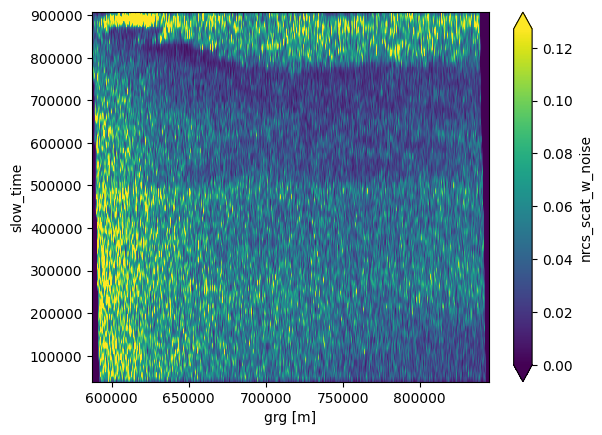

In [7]:
# test.data.V_leakage_pulse_rg.T.plot(robust = True)
test.data.nrcs_scat_w_noise.T.plot(robust = True)

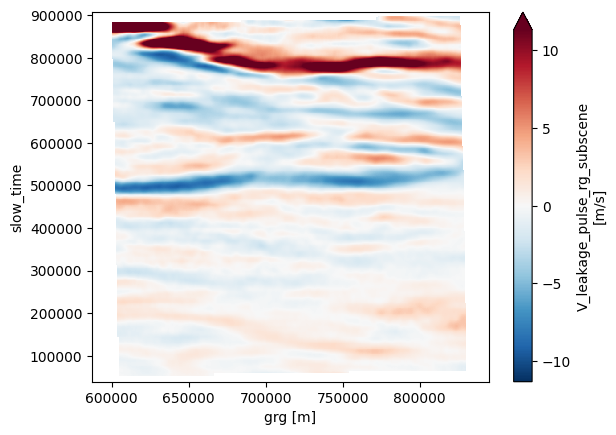

In [5]:
# test.data.V_leakage_pulse_rg.T.plot(robust = True)
test.data.V_leakage_pulse_rg_subscene.T.plot(robust = True)

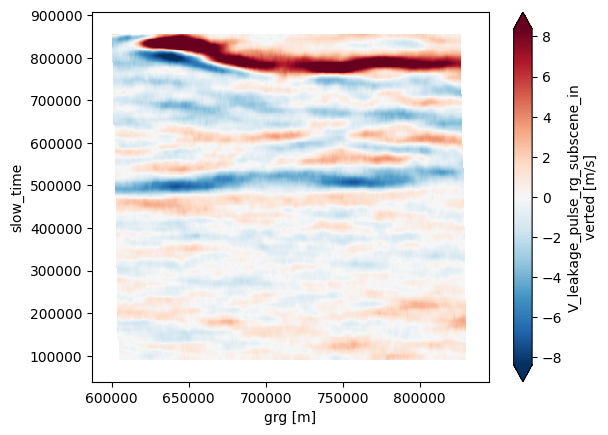

In [6]:
# test.data.V_leakage_pulse_rg.T.plot(robust = True)
test.data.V_leakage_pulse_rg_subscene_inverted.T.plot(robust = True)